# <span style='color:crimson'>La Poule Qui Chante _ Analyse exploratoire</span>

# Librairies

In [1]:
# Importation des librairies data
import pandas as pd
import numpy as np

# Importation des librairies graphiques
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go

# Importation librairie analyse exploratoire
from sklearn import preprocessing, decomposition
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans

#Warning
import warnings
warnings.filterwarnings('ignore')

# Fonctions

In [2]:
from matplotlib.collections import LineCollection

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,9))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color='darkblue', alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,9))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='10', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-6,6])
            plt.ylim([-6,6])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


# Chargement du fichier

In [3]:
# Importation
df_export_2018 = pd.read_csv('df_export_2018.csv', index_col=0)
# Résultat
df_export_2018.head()

Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                             
Afghanistan                                                5.0   
Afrique du Sud                                           150.0   
Albanie                                                   50.0   
Algérie                                                   23.0   
Allemagne                                                 67.0   

                Disponibilité alimentaire en quantit? (kg/personne/an)  \
Zone                                                                     
Afghanistan                                                  1.44        
Afrique du Sud                                              37.31        
Albanie                                                      9.48        
Algérie                                                      6.76        
Allemagne                                                   18.15        

                Disponibilité de matière grasse en quantité (g/personne/jour)  \
Zone                                                                            
Afghanistan                                                  0.31               
Afrique du Sud                                               9.67               
Albanie                                                      3.83               
Algérie                                                      1.59               
Allemagne                                                    3.92               

                Disponibilité de protéines en quantité (g/personne/jour)  \
Zone                                                                       
Afghanistan                                                  0.51          
Afrique du Sud                                              14.75          
Albanie                                                      3.52          
Algérie                                                      2.08          
Allemagne                                                    7.43          

                Disponibilité intérieure  Exportations - Quantité  \
Zone                                                                
Afghanistan                         53.0                      0.0   
Afrique du Sud                    2156.0                     48.0   
Albanie                             27.0                      NaN   
Algérie                            286.0                      0.0   
Allemagne                         1666.0                    640.0   

                Importations - Quantité  Nourriture  Production  Résidus  ...  \
Zone                                                                      ...   
Afghanistan                        25.0        53.0        29.0      0.0  ...   
Afrique du Sud                    515.0      2156.0      1762.0      0.0  ...   
Albanie                            12.0        27.0        16.0      0.0  ...   
Algérie                             0.0       286.0       286.0      0.0  ...   
Allemagne                         871.0      1509.0      1571.0      0.0  ...   

                Trafic de conteneurs dans les ports (TEU : unités équivalents 20 pieds)  \
Zone                                                                                      
Afghanistan                                                   NaN                         
Afrique du Sud                                          4892400.0                         
Albanie                                                   13648.0                         
Algérie                                                 1032000.0                         
Allemagne                                              19706500.0                         

                Transport aérien, fret (millions de tonnes-kilomètres)  iso_o  \
Zone                                                                            
Afghanistan                                             29.559349         FRA   


In [4]:
# Dimension
df_export_2018.shape

(167, 26)

In [5]:
# Information
df_export_2018.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167 entries, Afghanistan to Zimbabwe
Data columns (total 26 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Disponibilité alimentaire (Kcal/personne/jour)                                     167 non-null    float64
 1   Disponibilité alimentaire en quantit? (kg/personne/an)                             167 non-null    float64
 2   Disponibilité de matière grasse en quantité (g/personne/jour)                      167 non-null    float64
 3   Disponibilité de protéines en quantité (g/personne/jour)                           167 non-null    float64
 4   Disponibilité intérieure                                                           167 non-null    float64
 5   Exportations - Quantité                                                            131 non-null 

# Ajout de champs calculés

Pour éviter d'avoir trop d'outliers, je calcule des nouvelles variables pour avoir la quantité par habitant.

In [6]:
# Création de nouvelles colonnes
df_export_2018['disponibilité intérieure par habitant'] = df_export_2018['Disponibilité intérieure']/df_export_2018['Population totale']
df_export_2018['Production par habitant'] = df_export_2018['Production']/df_export_2018['Population totale']
df_export_2018['Exportations par habitant'] = df_export_2018['Exportations - Quantité']/df_export_2018['Population totale']
df_export_2018['Importations par habitant'] = df_export_2018['Importations - Quantité']/df_export_2018['Population totale']
# Résultat
df_export_2018.head()

Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                             
Afghanistan                                                5.0   
Afrique du Sud                                           150.0   
Albanie                                                   50.0   
Algérie                                                   23.0   
Allemagne                                                 67.0   

                Disponibilité alimentaire en quantit? (kg/personne/an)  \
Zone                                                                     
Afghanistan                                                  1.44        
Afrique du Sud                                              37.31        
Albanie                                                      9.48        
Algérie                                                      6.76        
Allemagne                                                   18.15        

                Disponibilité de matière grasse en quantité (g/personne/jour)  \
Zone                                                                            
Afghanistan                                                  0.31               
Afrique du Sud                                               9.67               
Albanie                                                      3.83               
Algérie                                                      1.59               
Allemagne                                                    3.92               

                Disponibilité de protéines en quantité (g/personne/jour)  \
Zone                                                                       
Afghanistan                                                  0.51          
Afrique du Sud                                              14.75          
Albanie                                                      3.52          
Algérie                                                      2.08          
Allemagne                                                    7.43          

                Disponibilité intérieure  Exportations - Quantité  \
Zone                                                                
Afghanistan                         53.0                      0.0   
Afrique du Sud                    2156.0                     48.0   
Albanie                             27.0                      NaN   
Algérie                            286.0                      0.0   
Allemagne                         1666.0                    640.0   

                Importations - Quantité  Nourriture  Production  Résidus  ...  \
Zone                                                                      ...   
Afghanistan                        25.0        53.0        29.0      0.0  ...   
Afrique du Sud                    515.0      2156.0      1762.0      0.0  ...   
Albanie                            12.0        27.0        16.0      0.0  ...   
Algérie                             0.0       286.0       286.0      0.0  ...   
Allemagne                         871.0      1509.0      1571.0      0.0  ...   

                     dist   distcap  iso3       area  continent  \
Zone                                                              
Afghanistan     5590.3810  5590.381   AFG   652225.0       Asia   
Afrique du Sud  9353.5520  8692.812   ZAF  1219912.0     Africa   
Albanie         1603.5340  1603.534   ALB    28748.0     Europe   
Algérie         1340.3900  1340.390   DZA  2381741.0     Africa   
Allemagne        439.8984   880.187   DEU   357325.0     Europe   

                Coût des procédures d’exportation, formalités documentaires (USD)  \
Zone                                                                                
Afghanistan                                                 344.4                   
Afrique du Sud                                               55.0                   
Albanie                                                      10.0      

In [7]:
# Suppression des colonnes inutiles
df_export_2018.drop(columns={'Disponibilité intérieure','Production','Exportations - Quantité','Importations - Quantité','Population totale','Disponibilité alimentaire en quantit? (kg/personne/an)','Disponibilité de matière grasse en quantité (g/personne/jour)','distcap'}, inplace=True)
# Résultat
df_export_2018.head()

Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                             
Afghanistan                                                5.0   
Afrique du Sud                                           150.0   
Albanie                                                   50.0   
Algérie                                                   23.0   
Allemagne                                                 67.0   

                Disponibilité de protéines en quantité (g/personne/jour)  \
Zone                                                                       
Afghanistan                                                  0.51          
Afrique du Sud                                              14.75          
Albanie                                                      3.52          
Algérie                                                      2.08          
Allemagne                                                    7.43          

                Nourriture  Résidus  Variation de stock  \
Zone                                                      
Afghanistan           53.0      0.0                 0.0   
Afrique du Sud      2156.0      0.0                72.0   
Albanie               27.0      0.0                 0.0   
Algérie              286.0      0.0                 0.0   
Allemagne           1509.0      0.0               135.0   

                PIB par habitant, ($ PPA internationaux constants de 2011)  \
Zone                                                                         
Afghanistan                                                2033.8            
Afrique du Sud                                            12627.9            
Albanie                                                   13323.8            
Algérie                                                   11642.2            
Allemagne                                                 53463.4            

                Stabilité politique et absence de violence/terrorisme (indice)  \
Zone                                                                             
Afghanistan                                                 -2.75                
Afrique du Sud                                              -0.22                
Albanie                                                      0.38                
Algérie                                                     -0.83                
Allemagne                                                    0.60                

                Densité de la population (personnes par kilomètre carré de superficie des terres)  \
Zone                                                                                                
Afghanistan                                             56.937049                                   
Afrique du Sud                                          47.640752                                   
Albanie                                                104.612263                                   
Algérie                                                 17.730062                                   
Allemagne                                              237.294012                                   

                Inflation, prix à la consommation (% annuel)  \
Zone                                                           
Afghanistan                                         0.626149   
Afrique du Sud                                      4.504577   
Albanie                                             2.028060   
Algérie                                             4.269990   
Allemagne                                           1.732168   

                Trafic de conteneurs dans les ports (TEU : unités équivalents 20 pieds)  \
Zone                                                                                      
Afghanistan                                                   NaN                         
Afrique du Sud                                        

# Corrélation entre les variables

Pour sélectionner les variables les plus pertinentes pour mon analyse, je regarde les corrélations entre elles.

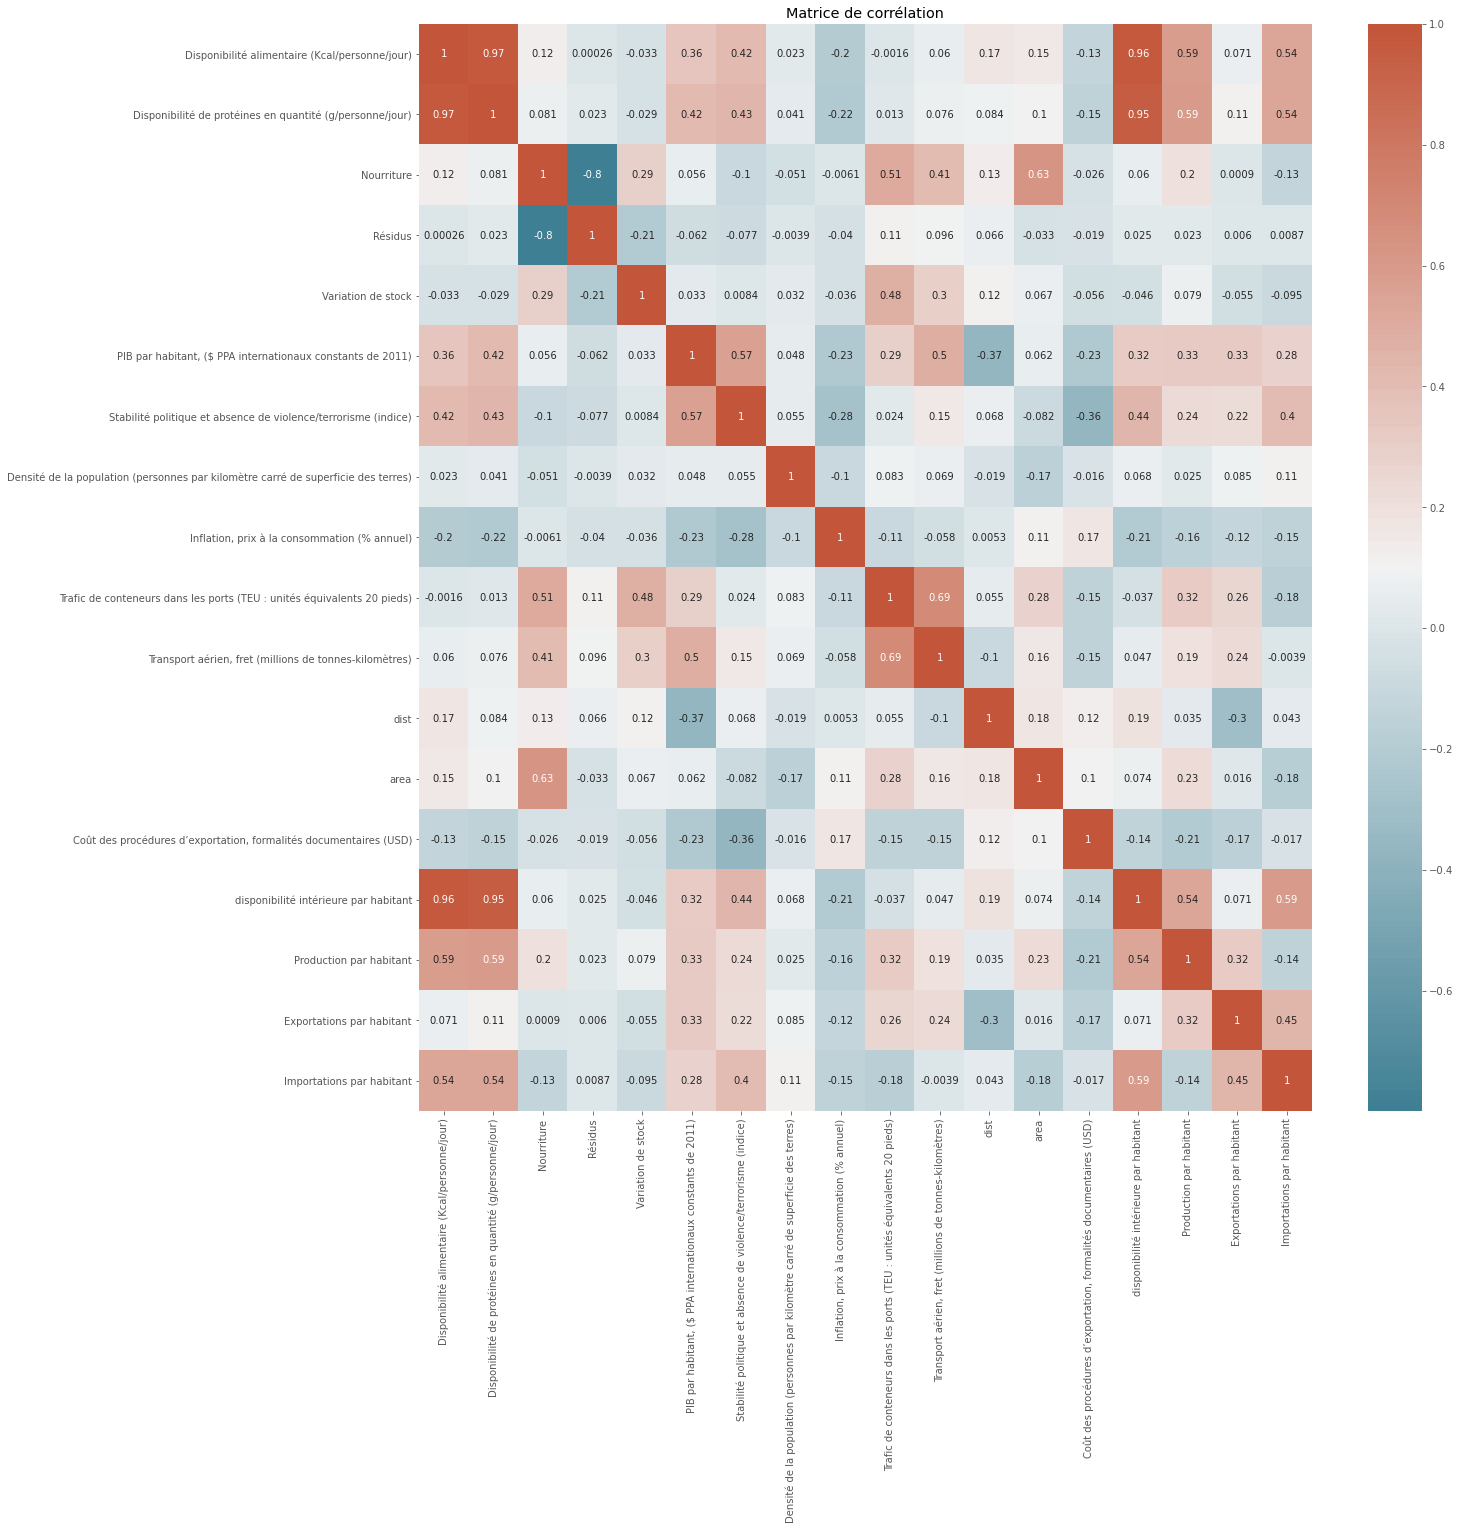

In [8]:
# Matrice de corrélation
matrice_correlation = df_export_2018.corr()
# Visualisation de la matrice avec une heatmap
plt.figure(figsize=(20,20))
sns.heatmap(matrice_correlation, cmap=sns.diverging_palette(220,20, n=200), annot=True)
plt.title('Matrice de corrélation')
plt.show()

# Exploration des données

## Préparation des données

Pour la suite de l'analyse, je ne garde que les variables les plus corrélées entre elles.

In [9]:
# Variables choisies
variables = ['disponibilité intérieure par habitant','Production par habitant','PIB par habitant, ($ PPA internationaux constants de 2011)','Stabilité politique et absence de violence/terrorisme (indice)','Importations par habitant','Disponibilité alimentaire (Kcal/personne/jour)','Disponibilité de protéines en quantité (g/personne/jour)','Trafic de conteneurs dans les ports (TEU : unités équivalents 20 pieds)','Transport aérien, fret (millions de tonnes-kilomètres)']
# Nouveau df avec les variables choisies
df_pca = df_export_2018[variables]
# Résultat
df_pca.head()

disponibilité intérieure par habitant  \
Zone                                                    
Afghanistan                                  0.001426   
Afrique du Sud                               0.037306   
Albanie                                      0.009366   
Algérie                                      0.006773   
Allemagne                                    0.020042   

                Production par habitant  \
Zone                                      
Afghanistan                    0.000780   
Afrique du Sud                 0.030488   
Albanie                        0.005550   
Algérie                        0.006773   
Allemagne                      0.018899   

                PIB par habitant, ($ PPA internationaux constants de 2011)  \
Zone                                                                         
Afghanistan                                                2033.8            
Afrique du Sud                                            12627.9            
Albanie                                                   13323.8            
Algérie                                                   11642.2            
Allemagne                                                 53463.4            

                Stabilité politique et absence de violence/terrorisme (indice)  \
Zone                                                                             
Afghanistan                                                 -2.75                
Afrique du Sud                                              -0.22                
Albanie                                                      0.38                
Algérie                                                     -0.83                
Allemagne                                                    0.60                

                Importations par habitant  \
Zone                                        
Afghanistan                      0.000673   
Afrique du Sud                   0.008911   
Albanie                          0.004163   
Algérie                          0.000000   
Allemagne                        0.010478   

                Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                             
Afghanistan                                                5.0   
Afrique du Sud                                           150.0   
Albanie                                                   50.0   
Algérie                                                   23.0   
Allemagne                                                 67.0   

                Disponibilité de protéines en quantité (g/personne/jour)  \
Zone                                                                       
Afghanistan                                                  0.51          
Afrique du Sud                                              14.75          
Albanie                                                      3.52          
Algérie                                                      2.08          
Allemagne                                                    7.43          

                Trafic de conteneurs dans les ports (TEU : unités équivalents 20 pieds)  \
Zone                                                                                      
Afghanistan                                                   NaN                         
Afrique du Sud                                          4892400.0                         
Albanie                                                   13648.0                         
Algérie                                                 1032000.0                         
Allemagne                                              19706500.0                         

                Transport aérien, fret (millions de tonnes-kilomètres)  
Zone                                                                    
Afghanistan                                             29.559349       
Afrique du Sud         

In [10]:
# Dimensions
df_pca.shape

(167, 9)

In [11]:
# Suppression des données pour la France
df_pca.drop(index={'France'}, inplace=True)

In [12]:
# Taux de valeurs nulles
df_pca.isna().mean()

disponibilité intérieure par habitant                                      0.000000
Production par habitant                                                    0.012048
PIB par habitant, ($ PPA internationaux constants de 2011)                 0.042169
Stabilité politique et absence de violence/terrorisme (indice)             0.006024
Importations par habitant                                                  0.000000
Disponibilité alimentaire (Kcal/personne/jour)                             0.000000
Disponibilité de protéines en quantité (g/personne/jour)                   0.000000
Trafic de conteneurs dans les ports (TEU : unités équivalents 20 pieds)    0.289157
Transport aérien, fret (millions de tonnes-kilomètres)                     0.277108
dtype: float64

In [13]:
# Suppression des colonnes avec trop de valeurs manquantes
df_pca.drop(columns={'Trafic de conteneurs dans les ports (TEU : unités équivalents 20 pieds)','Transport aérien, fret (millions de tonnes-kilomètres)'}, inplace=True)

In [14]:
# Suppression des valeurs manquantes
df_pca.dropna(inplace=True)

In [15]:
# Dimensions
df_pca.shape

(157, 7)

## Visualisation

In [16]:
df_pca.describe().T

count          mean  \
disponibilité intérieure par habitant               157.0      0.022725   
Production par habitant                             157.0      0.016717   
PIB par habitant, ($ PPA internationaux constan...  157.0  20282.334395   
Stabilité politique et absence de violence/terr...  157.0     -0.076115   
Importations par habitant                           157.0      0.010921   
Disponibilité alimentaire (Kcal/personne/jour)      157.0     77.802548   
Disponibilité de protéines en quantité (g/perso...  157.0      7.504841   

                                                             std         min  \
disponibilité intérieure par habitant                   0.019085    0.000452   
Production par habitant                                 0.017685    0.000000   
PIB par habitant, ($ PPA internationaux constan...  21010.450506  761.500000   
Stabilité politique et absence de violence/terr...      0.922678   -2.750000   
Importations par habitant                               0.017961    0.000000   
Disponibilité alimentaire (Kcal/personne/jour)         64.379428    1.000000   
Disponibilité de protéines en quantité (g/perso...      5.970865    0.140000   

                                                            25%           50%  \
disponibilité intérieure par habitant                  0.007605      0.019315   
Production par habitant                                0.001887      0.010638   
PIB par habitant, ($ PPA internationaux constan...  4739.500000  13323.800000   
Stabilité politique et absence de violence/terr...    -0.600000      0.000000   
Importations par habitant                              0.000673      0.004048   
Disponibilité alimentaire (Kcal/personne/jour)        23.000000     66.000000   
Disponibilité de protéines en quantité (g/perso...     2.570000      6.800000   

                                                             75%  \
disponibilité intérieure par habitant                   0.032884   
Production par habitant                                 0.026729   
PIB par habitant, ($ PPA internationaux constan...  28523.500000   
Stabilité politique et absence de violence/terr...      0.750000   
Importations par habitant                               0.011772   
Disponibilité alimentaire (Kcal/personne/jour)        112.000000   
Disponibilité de protéines en quantité (g/perso...     11.650000   

                                                              max  
disponibilité intérieure par habitant                    0.081662  
Production par habitant                                  0.078267  
PIB par habitant, ($ PPA internationaux constan...  132417.000000  
Stabilité politique et absence de violence/terr...       1.540000  
Importations par habitant                                0.111371  
Disponibilité alimentaire (Kcal/personne/jour)         266.000000  
Disponibilité de protéines en quantité (g/perso...      31.730000

Pour une meilleure visualisation de la distribution des variables, je réalise plusieurs graphiques.

In [17]:
# Boxplot avec les champs calculés
fig = go.Figure()
fig.add_trace(go.Box(x=df_pca['disponibilité intérieure par habitant'], name='Disponibilité intérieure par habitant'))
fig.add_trace(go.Box(x=df_pca['Production par habitant'], name='Production par habitant'))
fig.add_trace(go.Box(x=df_pca['Importations par habitant'], name='Importations par habitant'))
fig.update_layout(xaxis_title='Valeurs', showlegend=False)
fig.show()

In [18]:
# Boxplot PIB
fig = go.Figure()
fig.add_trace(go.Box(x=df_pca['PIB par habitant, ($ PPA internationaux constants de 2011)'], name='PIB par habitant'))
fig.update_layout(xaxis_title='Valeurs', width=800, height=300)
fig.show()

In [19]:
# Boxplot 'Stabilité politique'
fig = go.Figure()
fig.add_trace(go.Box(x=df_pca['Stabilité politique et absence de violence/terrorisme (indice)'], name='Stabilité politique'))
fig.update_layout(xaxis_title='Valeurs', width=800, height=300)
fig.show()

In [20]:
# Boxplot 'Disponibilité alimentaire'
fig = go.Figure()
fig.add_trace(go.Box(x=df_pca['Disponibilité alimentaire (Kcal/personne/jour)'], name='Disponibilité alimentaire par habitant'))
fig.update_layout(xaxis_title='Valeurs', width=800, height=300)
fig.show()

In [21]:
# Boxplot 'Disponibilité de protéines'
fig = go.Figure()
fig.add_trace(go.Box(x=df_pca['Disponibilité de protéines en quantité (g/personne/jour)'], name='Disponibilité de protéines par habitant'))
fig.update_layout(xaxis_title='Valeurs', width=800, height=300)
fig.show()

Seules les variables 'PIB', 'Disponibilité de protéines' et 'Importations' ont des outliers significatifs.

Je réalise une détection des outliers via la méthode du z-score.

## Détection des outliers

In [22]:
# Calcul du Z-score
from scipy import stats
z = np.abs(stats.zscore(df_pca))

In [23]:
# Les données supérieure au seuil sont considérées comme outliers
seuil = 3    # Seuil par défaut
print(np.where(z>3))

(array([  6,  12,  30,  31,  64,  66,  66,  82, 127, 127, 127, 129, 129],
      dtype=int64), array([4, 4, 4, 2, 2, 1, 6, 2, 0, 4, 6, 0, 4], dtype=int64))


In [24]:
# Suppression des outliers du df_pca
df_pca = df_pca[(z<3).all(axis=1)]
# Résultat 
df_pca.head()

disponibilité intérieure par habitant  \
Zone                                                    
Afghanistan                                  0.001426   
Afrique du Sud                               0.037306   
Albanie                                      0.009366   
Algérie                                      0.006773   
Allemagne                                    0.020042   

                Production par habitant  \
Zone                                      
Afghanistan                    0.000780   
Afrique du Sud                 0.030488   
Albanie                        0.005550   
Algérie                        0.006773   
Allemagne                      0.018899   

                PIB par habitant, ($ PPA internationaux constants de 2011)  \
Zone                                                                         
Afghanistan                                                2033.8            
Afrique du Sud                                            12627.9            
Albanie                                                   13323.8            
Algérie                                                   11642.2            
Allemagne                                                 53463.4            

                Stabilité politique et absence de violence/terrorisme (indice)  \
Zone                                                                             
Afghanistan                                                 -2.75                
Afrique du Sud                                              -0.22                
Albanie                                                      0.38                
Algérie                                                     -0.83                
Allemagne                                                    0.60                

                Importations par habitant  \
Zone                                        
Afghanistan                      0.000673   
Afrique du Sud                   0.008911   
Albanie                          0.004163   
Algérie                          0.000000   
Allemagne                        0.010478   

                Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                             
Afghanistan                                                5.0   
Afrique du Sud                                           150.0   
Albanie                                                   50.0   
Algérie                                                   23.0   
Allemagne                                                 67.0   

                Disponibilité de protéines en quantité (g/personne/jour)  
Zone                                                                      
Afghanistan                                                  0.51         
Afrique du Sud                                              14.75         
Albanie                                                      3.52         
Algérie                                                      2.08         
Allemagne                                                    7.43

In [25]:
# Dimension
df_pca.shape

(148, 7)

# ACP

## Dimensions des données

In [26]:
# Récupération du nombre de variables et d'observations
n = df_pca.shape[0] # Nombre d'observations
p = df_pca.shape[1] # Nombre de variables
print('Le nombre d\'observations est de',n,' et le nombre de variables est de',p)

Le nombre d'observations est de 148  et le nombre de variables est de 7


## Calcul de l'ACP

In [27]:
# Transformation des données en array numpy
X = df_pca.values
pays = df_pca.index
features = df_pca.columns

In [28]:
# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [29]:
# Vérification moyenne
print(np.mean(X_scaled, axis=0))

[1.20024111e-17 1.92038577e-16 4.80096443e-17 3.60072332e-17
 1.02020494e-16 1.20024111e-17 3.60072332e-17]


In [30]:
# Vérification écart-type
print(np.std(X_scaled, axis=0))

[1. 1. 1. 1. 1. 1. 1.]


> Le centrage et la réduction ont bien fonctionné

In [31]:
# Recherche du bon nombre de dimensions
pca = decomposition.PCA(n_components=0.95)    # Calcul pour préserver 95% de la variance
pca.fit(X_scaled)

PCA(n_components=0.95)

In [32]:
# Taux de variance
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.6131775  0.15658346 0.14358546 0.05393035]
0.9672767541095905


> Pour conserver 95% de la variance, il faut réduire aux 4 premières composantes.

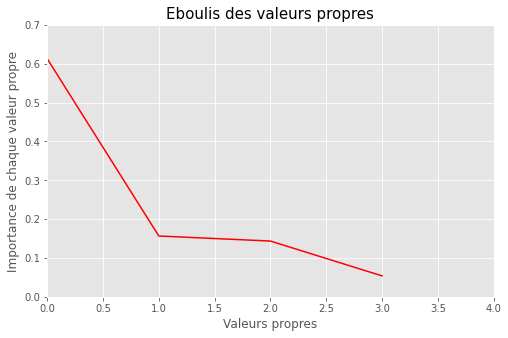

In [33]:
# Eboulis des valeurs propres
plt.figure(figsize=(8,5))
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color='red')
# Titres
plt.title('Eboulis des valeurs propres', fontsize=15)
plt.xlabel('Valeurs propres')
plt.ylabel('Importance de chaque valeur propre')
# Limites du graphique
plt.xlim([0,4])
plt.ylim([0,0.7])
plt.show()

> L'éboulis nous montre bien que la première composante principale représente près de 60% de la variance expliquée.

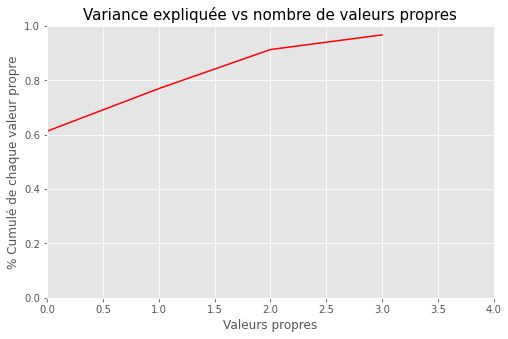

In [34]:
# Cumule de la variance expliquée
plt.figure(figsize=(8,5))
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), color='red')

# Limites du graphique
plt.xlim([0,4])
plt.ylim([0,1])

# Titres
plt.title('Variance expliquée vs nombre de valeurs propres', fontsize=15)
plt.xlabel('Valeurs propres')
plt.ylabel('% Cumulé de chaque valeur propre')
plt.show()

> Ce graphique démontre qu'il faut 4 composantes principales pour avoir 95% de la variance expliquée.

## Cercle des corrélations

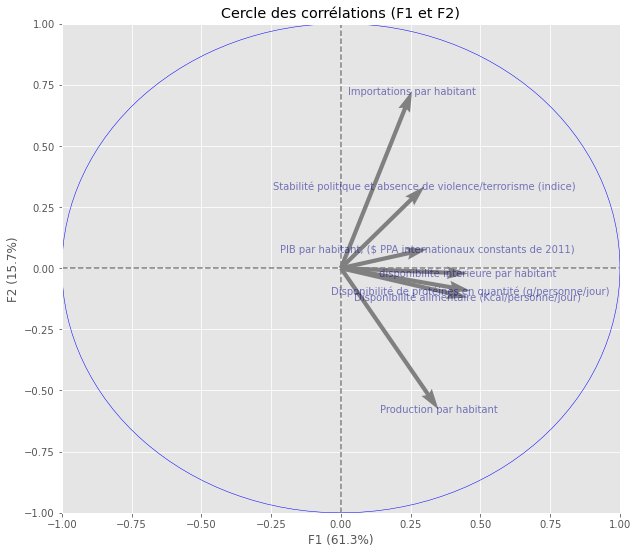

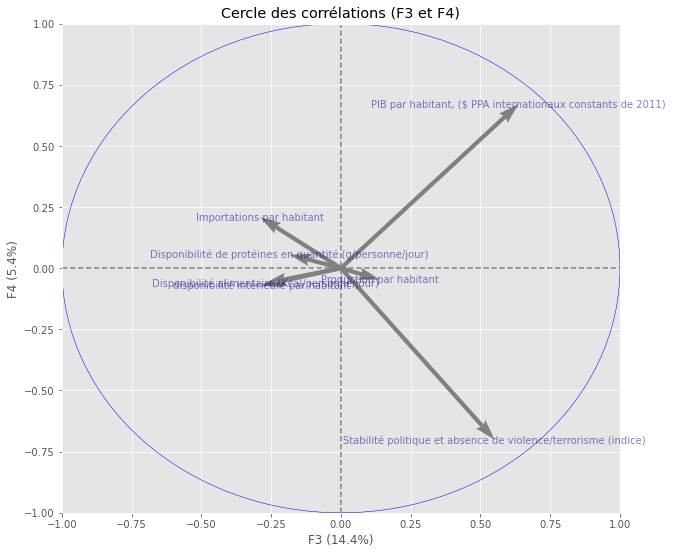

In [35]:
pcs = pca.components_
display_circles(pcs, 4, pca, [(0,1),(2,3)], labels = np.array(features))

Le cercle des corrélations nous apprend :

Dans le 1er plan factoriel:
- Les variables liées aux disponibilités sont corrélées positivement à F1 ainsi que le PIB et la stabilité politique mais de manière moins importante. 
- Les importations sont corrélées positivement à F2 tandis que la production est corrélée négativement à F2.

Dans le 2nd plan factoriel:
- Les variables du PIB et de la stabilité politique sont corrélées positivement à F3.

Plus un pays est stable et riche plus il a de disponibilité et plus un pays importe moins il produit.

In [36]:
# df centré réduit
df_normalise = pd.DataFrame(X_scaled, columns = df_pca.columns, index=df_pca.index)
# Résultat
df_normalise.head()

disponibilité intérieure par habitant  \
Zone                                                    
Afghanistan                                 -1.139777   
Afrique du Sud                               0.965278   
Albanie                                     -0.673927   
Algérie                                     -0.826080   
Allemagne                                   -0.047565   

                Production par habitant  \
Zone                                      
Afghanistan                   -0.935997   
Afrique du Sud                 0.799080   
Albanie                       -0.657403   
Algérie                       -0.586009   
Allemagne                      0.122237   

                PIB par habitant, ($ PPA internationaux constants de 2011)  \
Zone                                                                         
Afghanistan                                             -0.973908            
Afrique du Sud                                          -0.331141            
Albanie                                                 -0.288920            
Algérie                                                 -0.390946            
Allemagne                                                2.146435            

                Stabilité politique et absence de violence/terrorisme (indice)  \
Zone                                                                             
Afghanistan                                             -2.889661                
Afrique du Sud                                          -0.099191                
Albanie                                                  0.562580                
Algérie                                                 -0.771992                
Allemagne                                                0.805230                

                Importations par habitant  \
Zone                                        
Afghanistan                     -0.639814   
Afrique du Sud                   0.059001   
Albanie                         -0.343773   
Algérie                         -0.696861   
Allemagne                        0.191924   

                Disponibilité alimentaire (Kcal/personne/jour)  \
Zone                                                             
Afghanistan                                          -1.147190   
Afrique du Sud                                        1.366974   
Albanie                                              -0.366932   
Algérie                                              -0.835087   
Allemagne                                            -0.072168   

                Disponibilité de protéines en quantité (g/personne/jour)  
Zone                                                                      
Afghanistan                                             -1.223080         
Afrique du Sud                                           1.529014         
Albanie                                                 -0.641353         
Algérie                                                 -0.919654         
Allemagne                                                0.114314

In [37]:
# Dimension
df_normalise.shape

(148, 7)

In [38]:
X_projected = pca.fit_transform(X_scaled)
composantes_principales = pd.DataFrame(X_projected, index=df_normalise.index, columns=['F'+str(i+1) for i in range(4)])
# Résultat 
composantes_principales.head()

F1        F2        F3        F4
Zone                                                  
Afghanistan    -3.263482 -0.691228 -1.297939  1.366308
Afrique du Sud  1.929480 -0.803613 -1.097569 -0.244353
Albanie        -1.008015  0.414238  0.542755 -0.595373
Algérie        -1.915298 -0.252433  0.075973  0.219247
Allemagne       0.995901  0.505668  1.783870  0.923847

## Projection des individus

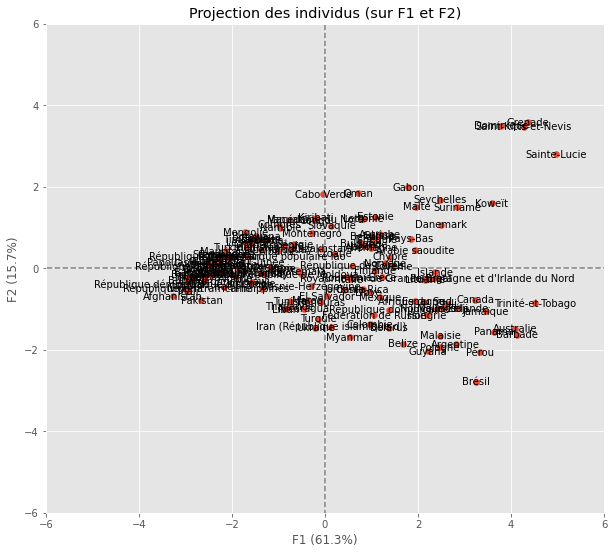

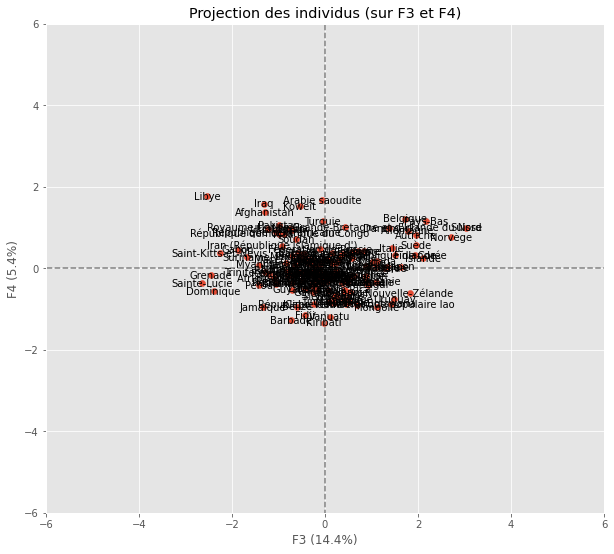

In [39]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, 4, pca, [(0,1),(2,3)], labels = np.array(pays))

# Clustering

## Clustering ascendant hierarchique

### Dendrogramme

In [40]:
# Clustering hierarchique
Z = linkage(X_scaled, 'ward')

In [41]:
# Importation de la librairie
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Dendrogramme')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = pays,
        orientation = "left",
    )
    plt.show()

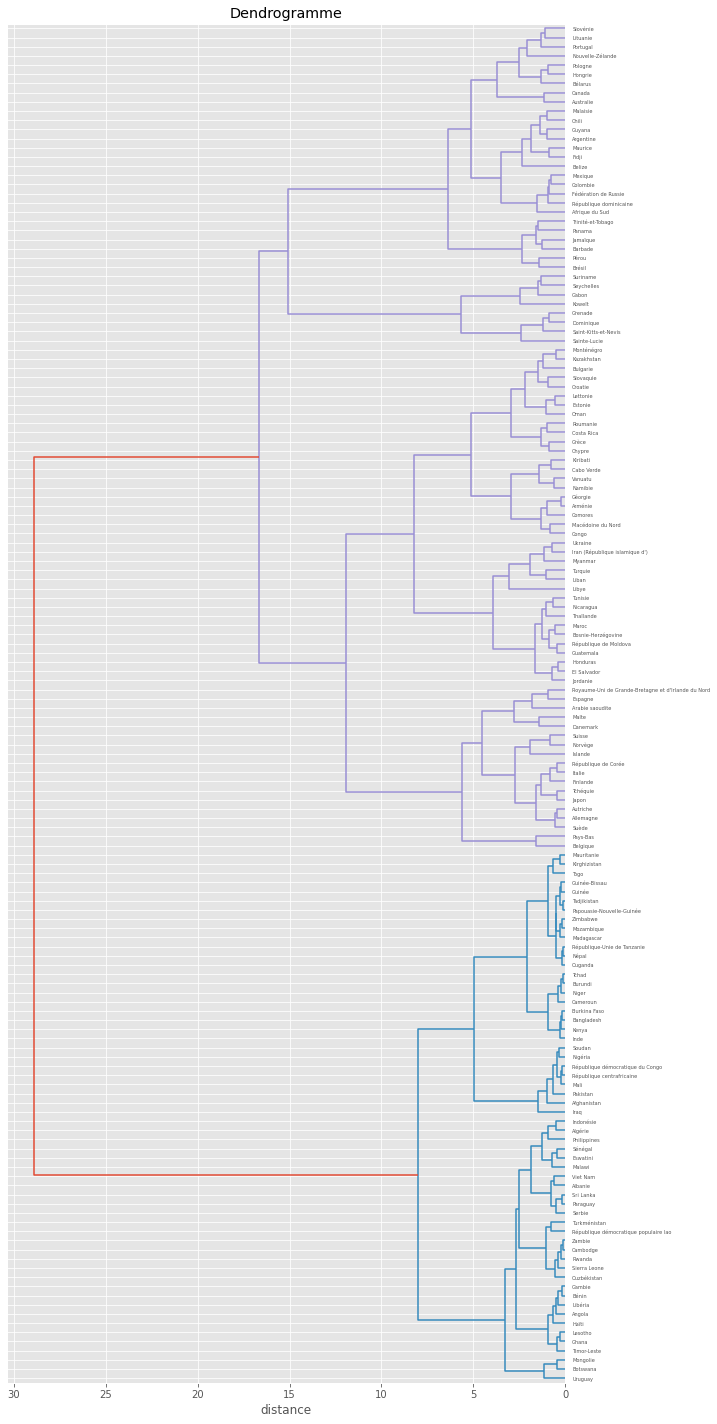

In [42]:
# Visualisation du dendrogramme
plot_dendrogram(Z,pays)

> J'identifie 3 à 4 clusters avec le dendrogramme.

### Projection sur le 1er plan factoriel

Pour plus de détail, je projette mon résultat sur le premier plan factoriel.

In [43]:
# Identification des classes à t=10 (distance)
groupe_cah = fcluster(Z,t=10,criterion='distance')
# Résultat
groupe_cah

array([1, 5, 1, 1, 2, 1, 2, 5, 3, 5, 2, 1, 5, 2, 5, 3, 1, 5, 3, 1, 1, 5,
       1, 3, 1, 1, 5, 5, 3, 5, 3, 3, 3, 3, 2, 4, 3, 2, 3, 1, 5, 2, 5, 4,
       1, 1, 4, 3, 3, 1, 1, 5, 3, 1, 3, 5, 1, 1, 3, 1, 2, 2, 5, 2, 3, 3,
       1, 1, 3, 4, 1, 3, 3, 3, 1, 5, 3, 1, 5, 1, 1, 2, 3, 5, 1, 5, 1, 3,
       1, 3, 3, 3, 1, 1, 2, 5, 1, 3, 1, 1, 1, 5, 1, 1, 2, 1, 5, 5, 5, 3,
       2, 1, 1, 2, 3, 5, 1, 1, 1, 4, 4, 1, 4, 1, 3, 5, 1, 1, 2, 4, 2, 1,
       1, 1, 2, 3, 1, 1, 5, 3, 1, 3, 3, 1, 3, 1, 1, 1], dtype=int32)

> A t=10, j'identifie 5 clusters.

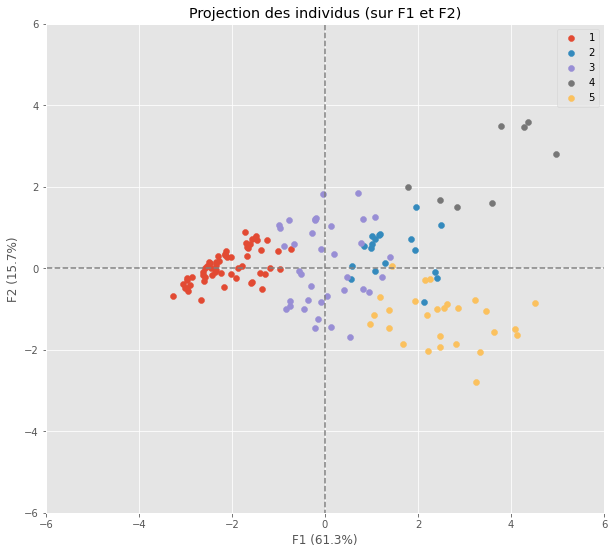

In [44]:
# Projection sur le 1er plan factoriel
display_factorial_planes(X_projected, 2, pca, [(0,1)], illustrative_var=groupe_cah)

In [45]:
# Création d'un df avec les pays identifiés par cluster
df_cah = pd.DataFrame({'Zone':df_pca.index, 'Groupe':groupe_cah})
df_cah = pd.merge(df_cah, df_normalise, on='Zone')
df_cah = df_cah.sort_values(['Groupe','Zone'])
df_cah

Zone  Groupe  disponibilité intérieure par habitant  \
0               Afghanistan       1                              -1.139777   
2                   Albanie       1                              -0.673927   
3                   Algérie       1                              -0.826080   
5                    Angola       1                              -0.507434   
11               Bangladesh       1                              -1.129631   
..                      ...     ...                                    ...   
107                Portugal       5                               0.635692   
108                   Pérou       5                               1.804553   
115  République dominicaine       5                               0.830271   
125                Slovénie       5                               0.216593   
138       Trinité-et-Tobago       5                               2.533514   

     Production par habitant  \
0                  -0.935997   
2                  -0.657403   
3                  -0.586009   
5                  -0.903840   
11                 -0.889274   
..                       ...   
107                 1.028599   
108                 1.906753   
115                 0.936450   
125                 0.957894   
138                 1.749867   

     PIB par habitant, ($ PPA internationaux constants de 2011)  \
0                                            -0.973908            
2                                            -0.288920            
3                                            -0.390946            
5                                            -0.676633            
11                                           -0.827864            
..                                                 ...            
107                                           0.968019            
108                                          -0.321828            
115                                          -0.022690            
125                                           1.206321            
138                                           0.495365            

     Stabilité politique et absence de violence/terrorisme (indice)  \
0                                            -2.889661                
2                                             0.562580                
3                                            -0.771992                
5                                            -0.209486                
11                                           -0.948465                
..                                                 ...                
107                                           1.400824                
108                                          -0.143309                
115                                           0.176547                
125                                           1.147145                
138                                           0.419196                

     Importations par habitant  \
0                    -0.639814   
2                    -0.343773   
3                    -0.696861   
5                     0.225420   
11                   -0.696861   
..                         ...   
107                   0.006114   
108                  -0.511251   
115                  -0.465394   
125                   0.242048   
138                   0.767852   

     Disponibilité alimentaire (Kcal/personne/jour)  \
0                                         -1.147190   
2                                         -0.366932   
3                                         -0.835087   
5                                         -0.522984   
11                                        -1.112512   
..                                              ...   
107                                        0.725429   
108                                        2.043198   
115                                        0.881480   
125                                        0.170579   
138                          

## Coefficient de Silhouette

[0.42160945 0.4267598  0.41365524 0.35273113 0.32603613 0.32371183
 0.30812183 0.29888463 0.30673539]


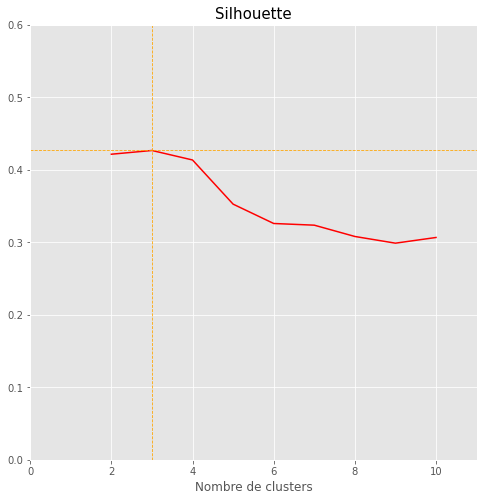

In [46]:
# Importation de la librairie 
from sklearn import metrics

# Variation du nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = KMeans(n_clusters=k+2)
    km.fit(X_scaled)
    res[k] = metrics.silhouette_score(X_scaled,km.labels_)
print(res)

# Visualisation
plt.figure(figsize=(8,8))
plt.title('Silhouette', fontsize=15)
plt.xlabel('Nombre de clusters')
plt.plot(np.arange(2,11,1),res, color='red')

# Ajout de lignes
plt.plot([3,3],[0,0.6], ls='--', c='orange', linewidth=0.8)
plt.plot([0,11],[0.428,0.428], ls='--', c='orange', linewidth=0.8)

# Limites du graphique
plt.xlim([0,11])
plt.ylim([0,0.6])
plt.show()

> Le coefficent de Silhouette nous montre une meilleur stabilité avec 3 clusters.

## K-means

### Elbow

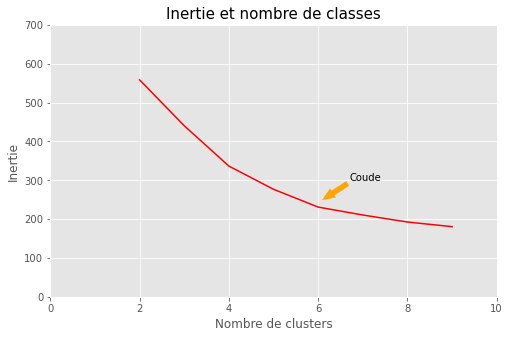

In [47]:
# Création d'une liste pour stocker les inerties
inerties = []
# On fait une boucle de 2 à 9 pour tester toutes les possibilités
for k in range(2,10):
    # Pour chaque k on créé un modèle et on l'ajuste
    kmeans= KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    # Stockage de l'inertie associée
    inerties.append(kmeans.inertia_)

# Visualisation
plt.figure(figsize=(8,5))
plt.plot(range(2,10), inerties, color='red')

#Ajout de texte
plt.annotate('Coude', xy=(6.1,250), xytext=(6.7,300), arrowprops={'color':'orange', 'width':5, 'headwidth':10})
plt.title('Inertie et nombre de classes', fontsize=15)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')

# Limite du graphique
plt.xlim([0,10])
plt.ylim([0,700])

plt.show()

> Avec la méthode du coude, on a 6 clusters.

### K-means

<Figure size 720x648 with 0 Axes>

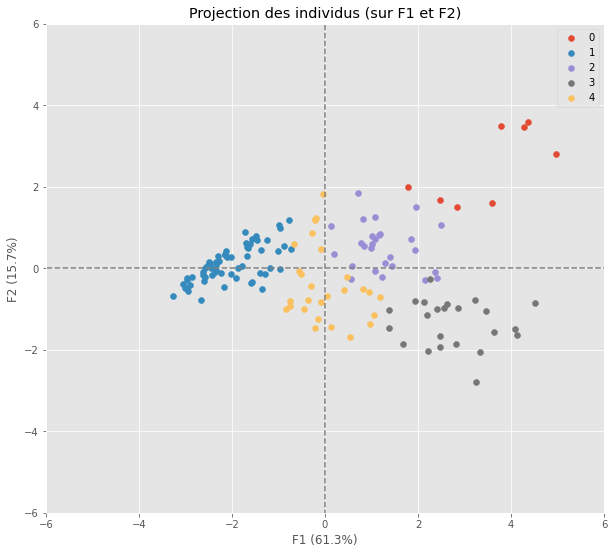

In [48]:
# Pour plus de clarté et de pertinence dans mon analyse, je pars sur 5 clusters
n_clust = 5

# Clustering par K-means
km = KMeans(n_clusters=n_clust, init='k-means++', n_init=5, random_state=30)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
plt.figure(figsize=(10,9))
display_factorial_planes(X_projected, 2, pca, [(0,1)], illustrative_var=clusters)


### Centroïdes

In [49]:
# Création d'un df avec le nombre de pays par clusters
count = pd.DataFrame(np.unique(clusters, return_counts=True)[1], columns=['Nombre de pays'])

# Stockage des centroïdes des clusters dans un df
centroide = pd.DataFrame(km.cluster_centers_, columns=df_pca.columns)

# Affichage de la concaténation de count et centroide dans un nouveau df
df_centroide = pd.concat([count, pd.DataFrame(centroide, columns=df_pca.columns)], axis=1).T
df_centroide

0          1  \
Nombre de pays                                      8.000000  62.000000   
disponibilité intérieure par habitant               2.103747  -0.880610   
Production par habitant                            -0.499758  -0.779583   
PIB par habitant, ($ PPA internationaux constan...  0.275957  -0.751914   
Stabilité politique et absence de violence/terr...  0.752840  -0.517424   
Importations par habitant                           3.260176  -0.440770   
Disponibilité alimentaire (Kcal/personne/jour)      1.776609  -0.888782   
Disponibilité de protéines en quantité (g/perso...  1.684833  -0.940570   

                                                            2          3  \
Nombre de pays                                      27.000000  23.000000   
disponibilité intérieure par habitant                0.133482   1.332329   
Production par habitant                              0.308418   1.772044   
PIB par habitant, ($ PPA internationaux constan...   1.561761   0.402157   
Stabilité politique et absence de violence/terr...   0.933908   0.619646   
Importations par habitant                            0.436105  -0.318586   
Disponibilité alimentaire (Kcal/personne/jour)       0.124341   1.432561   
Disponibilité de protéines en quantité (g/perso...   0.324400   1.371461   

                                                            4  
Nombre de pays                                      28.000000  
disponibilité intérieure par habitant                0.125724  
Production par habitant                              0.115997  
PIB par habitant, ($ PPA internationaux constan...  -0.250220  
Stabilité politique et absence de violence/terr...  -0.478922  
Importations par habitant                           -0.114322  
Disponibilité alimentaire (Kcal/personne/jour)       0.163767  
Disponibilité de protéines en quantité (g/perso...   0.161940

L'étude des centroïdes montre :
- cluster 0 : pays en voie de développement, avec des disponibilités raisonnables mais une mauvaise stabilité politique.
- cluster 1 : pays riches avec un fort PIB, ce sont les pays qui importent le plus.
- cluster 2 : pays pauvres, avec un faible PIB et une instabilité politique. Beaucoup d'insécurité alimentaire.
- cluster 3 : pays développés, PIB moyen mais stable politiquement. 
- cluster 4 : pays riches mais qui importent moins que les pays du cluster 1.

>*Observations : 
Le nombre de pays par clusters est plutôt bien réparti.*

# Heatmap

In [50]:
#index triés des groupes
idk = np.argsort(clusters)

#affichage des pays et de leurs groupes dans un nouveau df
df_kmeans = pd.DataFrame(df_normalise.index[idk], clusters[idk]).reset_index()
# Renommage de 'index' en 'clusters'
df_kmeans.rename(columns={'index':'cluster'}, inplace=True)
# Résultat
df_kmeans.head()

cluster       Zone
0        0    Grenade
1        0     Koweït
2        0      Gabon
3        0  Dominique
4        0   Suriname

In [51]:
# Dimension
df_kmeans.shape

(148, 2)

In [52]:
# Jointure de df_heatmap et de df_normalise
df_map = pd.merge(df_kmeans, df_normalise, on='Zone', how='outer')
# Résultat
df_map.head()

cluster       Zone  disponibilité intérieure par habitant  \
0        0    Grenade                               2.987759   
1        0     Koweït                               1.626855   
2        0      Gabon                               1.046629   
3        0  Dominique                               2.872154   
4        0   Suriname                               1.526739   

   Production par habitant  \
0                -0.457543   
1                -0.120461   
2                -0.871327   
3                -0.981561   
4                 0.133811   

   PIB par habitant, ($ PPA internationaux constants de 2011)  \
0                                          -0.077890            
1                                           1.965341            
2                                          -0.202729            
3                                          -0.397329            
4                                           0.055813            

   Stabilité politique et absence de violence/terrorisme (indice)  \
0                                           1.235381                
1                                           0.264783                
2                                          -0.132280                
3                                           1.356706                
4                                           0.220665                

   Importations par habitant  Disponibilité alimentaire (Kcal/personne/jour)  \
0                   4.630467                                        1.956502   
1                   2.316881                                        1.609721   
2                   2.505053                                        1.037532   
3                   4.040128                                        1.904485   
4                   2.542914                                        1.627060   

   Disponibilité de protéines en quantité (g/personne/jour)  
0                                           1.612117         
1                                           1.898150         
2                                           1.333816         
3                                           1.384065         
4                                           1.351210

In [53]:
# Dimensions
df_map.shape

(148, 9)

In [54]:
# Suppression de la colonne 'Zone'
df_heatmap = df_map.drop(columns={'Zone'})

In [55]:
# Group by index et moyenne pour chaque groupe
df_heatmap = df_heatmap.groupby(['cluster']).mean().T
# resultat
df_heatmap

cluster                                                    0         1  \
disponibilité intérieure par habitant               2.103747 -0.880610   
Production par habitant                            -0.499758 -0.779583   
PIB par habitant, ($ PPA internationaux constan...  0.275957 -0.751914   
Stabilité politique et absence de violence/terr...  0.752840 -0.517424   
Importations par habitant                           3.260176 -0.440770   
Disponibilité alimentaire (Kcal/personne/jour)      1.776609 -0.888782   
Disponibilité de protéines en quantité (g/perso...  1.684833 -0.940570   

cluster                                                    2         3  \
disponibilité intérieure par habitant               0.133482  1.332329   
Production par habitant                             0.308418  1.772044   
PIB par habitant, ($ PPA internationaux constan...  1.561761  0.402157   
Stabilité politique et absence de violence/terr...  0.933908  0.619646   
Importations par habitant                           0.436105 -0.318586   
Disponibilité alimentaire (Kcal/personne/jour)      0.124341  1.432561   
Disponibilité de protéines en quantité (g/perso...  0.324400  1.371461   

cluster                                                    4  
disponibilité intérieure par habitant               0.125724  
Production par habitant                             0.115997  
PIB par habitant, ($ PPA internationaux constan... -0.250220  
Stabilité politique et absence de violence/terr... -0.478922  
Importations par habitant                          -0.114322  
Disponibilité alimentaire (Kcal/personne/jour)      0.163767  
Disponibilité de protéines en quantité (g/perso...  0.161940

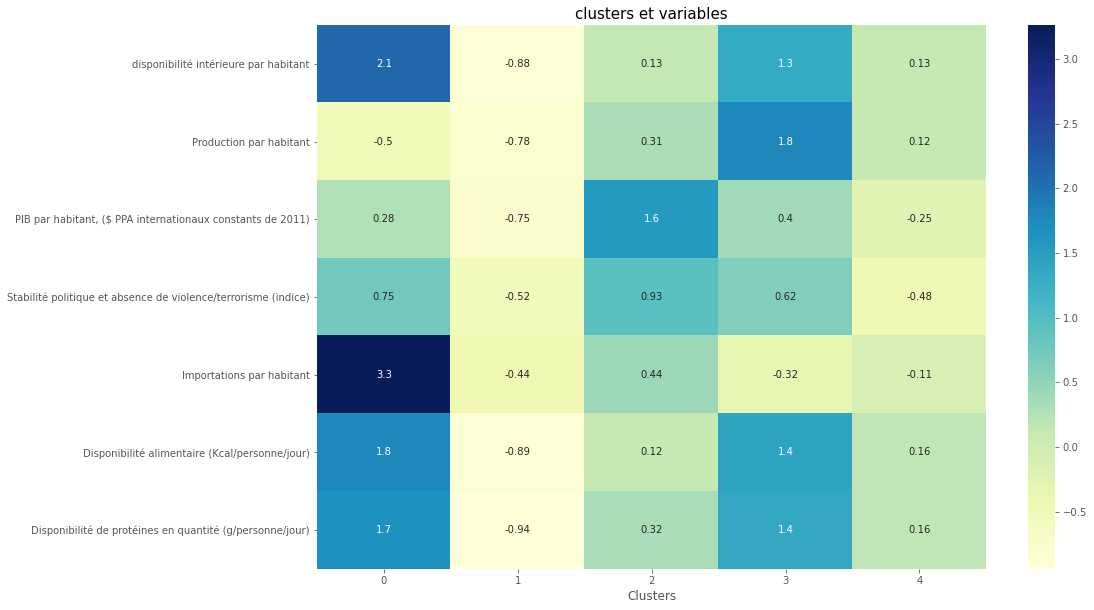

In [56]:
# Visualisation avec une heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True)
plt.title('clusters et variables', fontsize=15)
plt.xlabel('Clusters')
plt.show()

La heatmap confirme les résultats obtenus avec l'étude des centroïdes.

>L'export devrait se faire en priorité vers les pays du cluster 1 puis ceux du cluster 4.

Cependant, les pays du cluster 1 importent déjà en masse donc il faudrait étudier la concurrence locale pour savoir s'il y a une place suffisante pour les produits La poule qui chante.

# Carte

Réalisation d'une carte pour visualiser les différents pays selon les clusters auxquels ils appartiennent.

J'utilise le *df_map* préalablement créé.

In [57]:
# Import des normes iso3 pour la localisation des pays sur la carte
iso3 = pd.read_csv('iso_pays.csv', sep=';')
iso3 = iso3.rename(columns={'Column4':'iso_3','Column5':'Zone'})
# Résultat
iso3.head()

Column1  Column2 Column3 iso_3            Zone       Column6
0        1        4      AF   AFG     Afghanistan   Afghanistan
1      201      710      ZA   ZAF  Afrique du Sud  South Africa
2        2        8      AL   ALB         Albanie       Albania
3        4       12      DZ   DZA         Algérie       Algeria
4       84      276      DE   DEU       Allemagne       Germany

In [58]:
# Suppression des colonnes inutiles
iso3 = iso3.drop(columns=['Column1','Column2','Column3','Column6'])

In [59]:
# Jointure de df-map et iso3
df_map = pd.merge(df_map, iso3, on='Zone')
# Résultat
df_map.head()

cluster       Zone  disponibilité intérieure par habitant  \
0        0    Grenade                               2.987759   
1        0     Koweït                               1.626855   
2        0      Gabon                               1.046629   
3        0  Dominique                               2.872154   
4        0   Suriname                               1.526739   

   Production par habitant  \
0                -0.457543   
1                -0.120461   
2                -0.871327   
3                -0.981561   
4                 0.133811   

   PIB par habitant, ($ PPA internationaux constants de 2011)  \
0                                          -0.077890            
1                                           1.965341            
2                                          -0.202729            
3                                          -0.397329            
4                                           0.055813            

   Stabilité politique et absence de violence/terrorisme (indice)  \
0                                           1.235381                
1                                           0.264783                
2                                          -0.132280                
3                                           1.356706                
4                                           0.220665                

   Importations par habitant  Disponibilité alimentaire (Kcal/personne/jour)  \
0                   4.630467                                        1.956502   
1                   2.316881                                        1.609721   
2                   2.505053                                        1.037532   
3                   4.040128                                        1.904485   
4                   2.542914                                        1.627060   

   Disponibilité de protéines en quantité (g/personne/jour) iso_3  
0                                           1.612117          GRD  
1                                           1.898150          KWT  
2                                           1.333816          GAB  
3                                           1.384065          DMA  
4                                           1.351210          SUR

In [60]:
# Dimension
df_map.shape

(144, 10)

In [61]:
# Mise en index de la colonne 'Zone'
df_map = df_map.set_index('Zone')

In [62]:
# Conversion de la colonne 'cluster' en objet
df_map['cluster'] = df_map['cluster'].astype('str')

In [63]:
# Réalisation de la carte
fig = px.choropleth(df_map, locations=df_map['iso_3'], color=df_map['cluster'], title='Répartition des pays par cluster')
fig.show()

Avec la suppression des outliers, plusieurs pays ont été supprimés mais les résultats des clusters sont plus cohérents. *(j'ai essayé l'analyse sans traiter les outliers et le résultat n'est pas probant)*

# Conclusion

En conclusion, les pays situés dans les clusters 1 puis 4 sont les plus à même d'acheter les produits La Poule Qui Chante. Ces résultats corroborent avec la liste des pays où la France exporte le plus d'animaux. (Allemagne, Belgique, Italie, Espagne et Royaume-Uni).

Deux axes s'offrent à cette analyse :
- les pays du cluster 1 importent déjà beaucoup, il faudrait donc étudier l'analyse de la concurrence pour ces pays en locale et en internationale.
- **les pays du cluster 4 peuvent être priorisé** d'autant plus qu'ils sont en majorité issu de l'Union Européenne donc avec des procédures et des coûts d'exportations plus attractifs.